In [39]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

#### Overview
We're back to Minecraft, this time with some categories. As a reminder from last project, any given Minecraft world has a seed that is used to generate the world. That seed determines all randomness, including what biome you spawn in. While playing the game, it feels like it is disproportionately likely to spawn close to an ocean. To that end, this project aims to determine the distribution of the distance to the nearest ocean from the spawn point.

This time, we have a few categories of spawn points, based on their 'continentalness'. The categories are: `Ocean`, `Coast`, `Near inland`, `Mid inland`, and `Far inland`. This should make it a little easier to model, as we can separate the nice rounded distributions from the sharp ones. First, a data visualization to see what we're working with.

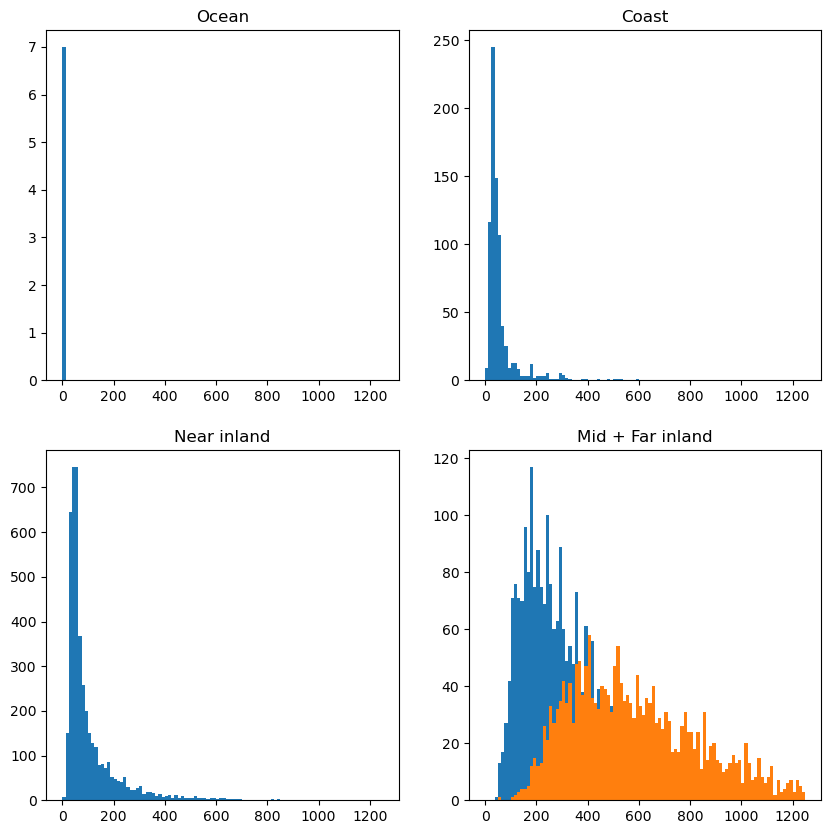

In [54]:
# Grab data
data = pd.read_csv('seedscraper_out.csv', dtype={'spawn_category':'category'})

# Plot data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.hist(data[data.spawn_category == 'Ocean'].distance, bins=100, range=(0, 1250))
ax1.set_title('Ocean')
ax2.hist(data[data.spawn_category == 'Coast'].distance, bins=100, range=(0, 1250))
ax2.set_title('Coast')
ax3.hist(data[data.spawn_category == 'Near inland'].distance, bins=100, range=(0, 1250))
ax3.set_title('Near inland')
ax4.hist(data[data.spawn_category == 'Mid inland'].distance, bins=100, range=(0, 1250))
ax4.hist(data[data.spawn_category == 'Far inland'].distance, bins=100, range=(0, 1250))
ax4.set_title('Mid + Far inland')

# Get categories for model
idx = data.spawn_category.cat.codes.values
coords = {"spawn_category": data.spawn_category.cat.categories}

#### Data
First, the `Ocean` category is most definitely going to throw our model for a loop. Every time you spawn in an ocean... you're 0 blocks from an ocean. The `Coast` and `Near inland` categories both look a lot like last projects data - sharp on the left with a tail to the right. This will likely be difficult to model. `Mid inland` and `Far inland` however, look relatively like a skew normal distribution. This should be easier to model, and should get better $\hat{R}$ values. Let's start with the model that includes all categories.

#### [Model 1] Intro
The final likelihood will be the same as last project - an ExGaussian distribution. The main difference is that every prior will have a hyperprior. The reason I want everything to be able to communicate across categories is that the underlying process creating them is exactly the same. We're simply sectioning off that data into nice groups. Much like using Gamma for the priors last project, I will use Gamma hyperpriors as well. With the underlying process being perlin randomness, I expect the priors to be relatively normal with a positive support.

Much like last project, I will be selecting values for my hyperprior parameters simply by a guess based on last project's result. The sheer amount of data I have should mostly override this, so I will keep the standard deviations fairly large.

In [41]:
with pm.Model(coords = coords) as model_bad:
    mu_mu = pm.Gamma('mu_mu', mu = 100, sigma = 40)                                     # mean of means of normal
    mu_sigma = pm.Gamma('mu_sigma', mu = 50, sigma = 20)                                # std dev of means of normal
    
    sigma_mu = pm.Gamma('sigma_mu', mu = 30, sigma = 20)                                # mean of std devs of normal
    sigma_sigma = pm.Gamma('sigma_sigma', mu = 20, sigma = 10)                          # std dev of std devs of normal
    
    nu_mu = pm.Gamma('nu_mu', mu = 600, sigma = 100)                                    # mean of scales of exponential
    nu_sigma = pm.Gamma('nu_sigma', mu = 70, sigma = 30)                                # std dev of scales of exponential

    mu = pm.Gamma('mu', mu=mu_mu, sigma=mu_sigma, dims="spawn_category")                # mean of normal
    sigma = pm.Gamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims="spawn_category")    # std dev of normal
    nu = pm.Gamma('nu', mu=nu_mu, sigma=nu_sigma, dims="spawn_category")                # scale of exponential
    
    y = pm.ExGaussian('y', mu=mu[idx], sigma=sigma[idx], nu=nu[idx], observed=data.distance)
    
    idata_bad = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, sigma_mu, sigma_sigma, nu_mu, nu_sigma, mu, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3500 divergences after tuning. Increase `target_accept` or reparameterize.


#### [Model 1] Results
As you may notice, 3,500 divergences is unideal. That said, this was to be expected. Before moving on, let's take a look at the trace plots and $\hat{R}$ values. Also included below is a visualization of the model, though it is fairly straightforward.

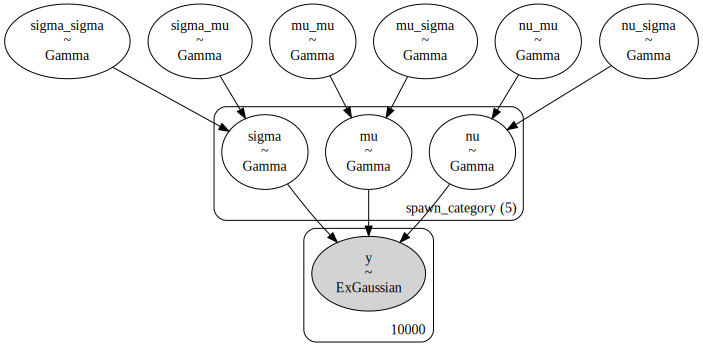

In [42]:
pm.model_to_graphviz(model_bad)

array([[<Axes: title={'center': 'mu_mu'}>,
        <Axes: title={'center': 'mu_mu'}>],
       [<Axes: title={'center': 'mu_sigma'}>,
        <Axes: title={'center': 'mu_sigma'}>],
       [<Axes: title={'center': 'sigma_mu'}>,
        <Axes: title={'center': 'sigma_mu'}>],
       [<Axes: title={'center': 'sigma_sigma'}>,
        <Axes: title={'center': 'sigma_sigma'}>],
       [<Axes: title={'center': 'nu_mu'}>,
        <Axes: title={'center': 'nu_mu'}>],
       [<Axes: title={'center': 'nu_sigma'}>,
        <Axes: title={'center': 'nu_sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

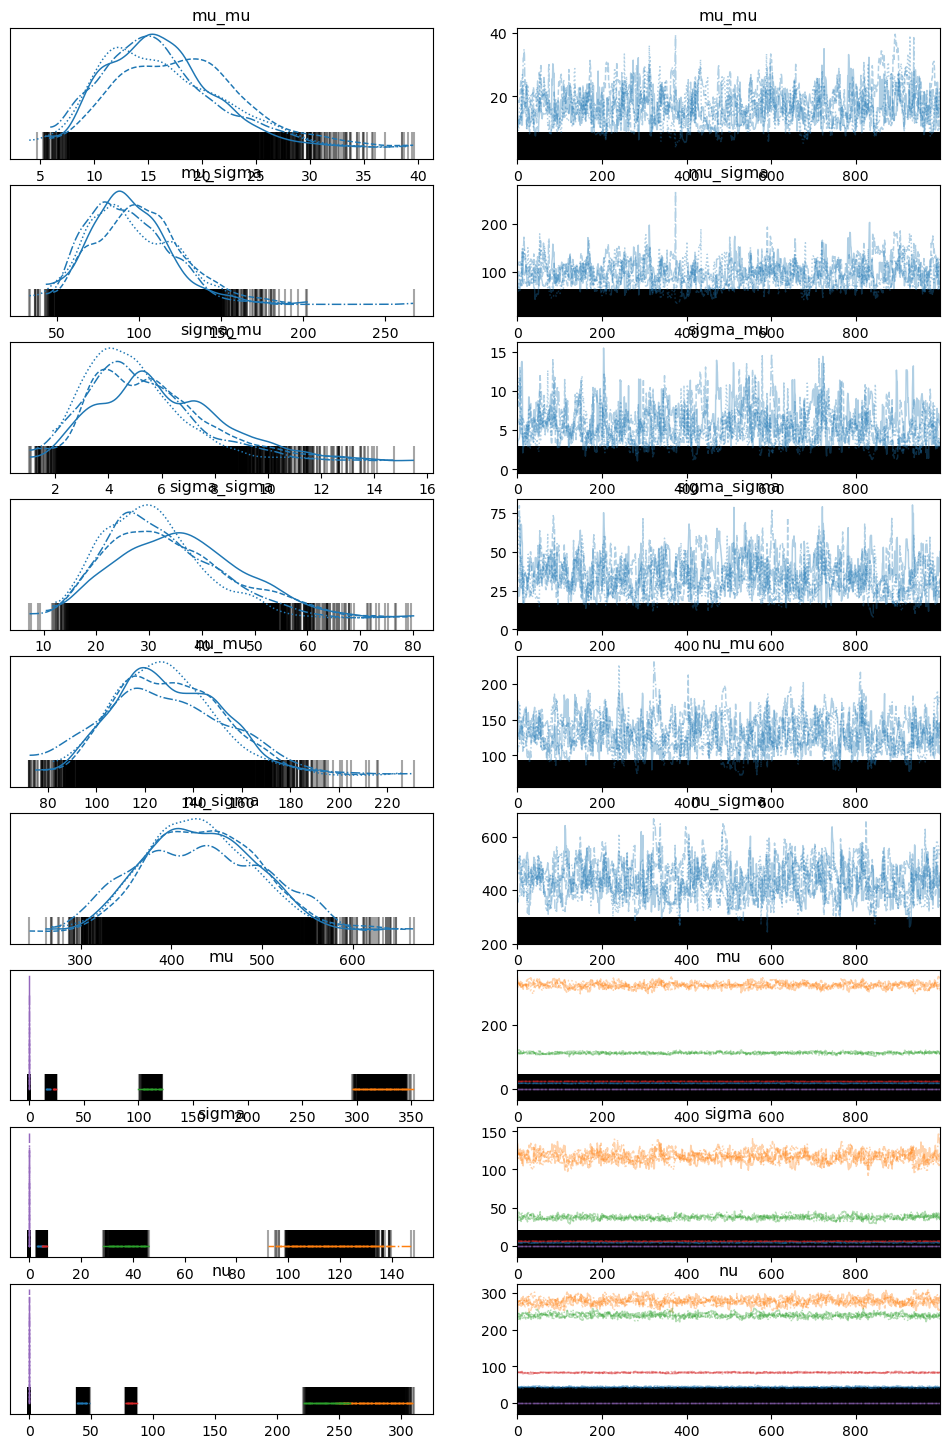

In [43]:
az.plot_trace(idata_bad)

In [44]:
az.rhat(idata_bad)

<xarray.Dataset>
Dimensions:         (spawn_category: 5)
Coordinates:
  * spawn_category  (spawn_category) <U11 'Coast' 'Far inland' ... 'Ocean'
Data variables:
    mu_mu           float64 1.032
    mu_sigma        float64 1.025
    sigma_mu        float64 1.022
    sigma_sigma     float64 1.021
    nu_mu           float64 1.021
    nu_sigma        float64 1.011
    mu              (spawn_category) float64 1.013 1.007 1.009 1.014 1.048
    sigma           (spawn_category) float64 1.009 1.012 1.011 1.014 1.047
    nu              (spawn_category) float64 1.012 1.01 1.017 1.008 1.009

#### [Model 1] Results cont.
The $\hat{R}$ values are actually not as bad as I expected. Certainly outside our desired 1.001 range, but not terrible. The trace plots are also not as bad as I expected. The first-degree priors (`mu`, `sigma`, and `nu`) are actually fairly flat, even though they look bad. The reason for that is definitely the `Ocean` category, as every value is always going to be 0. The divergences are a bit of a concern, but I will move on to the posterior predictive checks. I expect the model to be fairly bad, but I want to see how bad.

Sampling: [y]


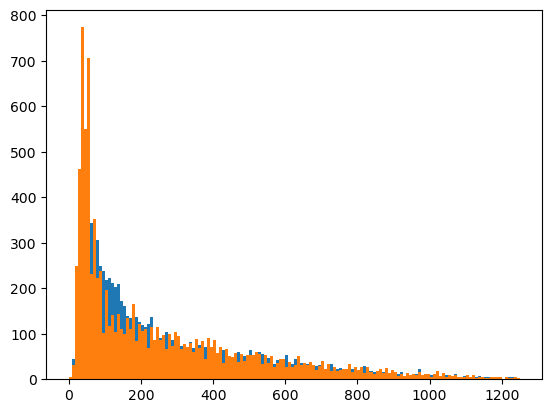

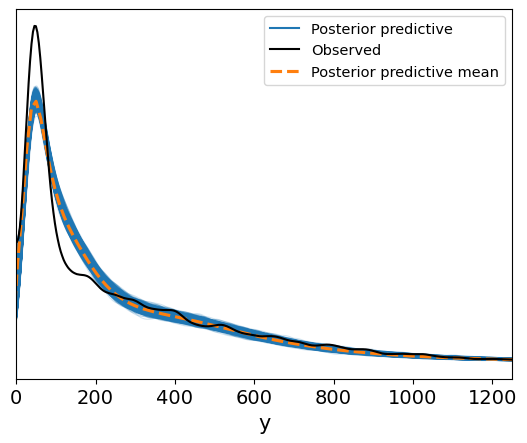

In [114]:
pm.sample_posterior_predictive(idata_bad, model=model_bad, extend_inferencedata=True)

prediction = az.extract(idata_bad, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values
plt.hist(prediction, bins=150, range=(0, 1250))
plt.hist(data.distance, bins=150, range=(0, 1250))

az.plot_ppc(idata_bad).set_xbound(lower=0, upper=1250)

#### [Model #1] Conclusion
Even with the divergences, this is significantly better than the non-hierarchical model. It has the same issue of being unable to capture both the steep descent and the sudden switch to a tail, but to a much smaller degree. This is likely because even though it is ultimately operating on the same data set, the nicer categories of `Far inland` and `Mid inland` can be modeled (somewhat) separately from the sharper categories. The peak is much closer to the actual data, and the tail is much more pronounced.

Now, I'm going to exclude the `Ocean`, `Coast`, and `Near inland` categories. I expect the model to be significantly better, as the data is much more well-behaved. I will also once again graph the trace plots and $\hat{R}$ values.

In [98]:
data = pd.read_csv('seedscraper_out.csv', dtype={'spawn_category':'category'})

data = data[data.spawn_category != 'Ocean'][data.spawn_category != 'Coast'][data.spawn_category != 'Near inland']
data.spawn_category = data.spawn_category.cat.remove_unused_categories()

idx = data.spawn_category.cat.codes.values
coords = {"spawn_category": data.spawn_category.cat.categories}

/var/folders/54/8bqrgnxj1bz12y26lmhvlz2h0000gn/T/ipykernel_16111/1263084491.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.spawn_category != 'Ocean'][data.spawn_category != 'Coast'][data.spawn_category != 'Near inland']
/var/folders/54/8bqrgnxj1bz12y26lmhvlz2h0000gn/T/ipykernel_16111/1263084491.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.spawn_category != 'Ocean'][data.spawn_category != 'Coast'][data.spawn_category != 'Near inland']


In [99]:
with pm.Model(coords = coords) as model:
    mu_mu = pm.Gamma('mu_mu', mu = 100, sigma = 40)                                     # mean of means of normal
    mu_sigma = pm.Gamma('mu_sigma', mu = 50, sigma = 20)                                # std dev of means of normal

    sigma_mu = pm.Gamma('sigma_mu', mu = 30, sigma = 20)                                # mean of std devs of normal
    sigma_sigma = pm.Gamma('sigma_sigma', mu = 20, sigma = 10)                          # std dev of std devs of normal

    nu_mu = pm.Gamma('nu_mu', mu = 600, sigma = 100)                                    # mean of scales of exponential
    nu_sigma = pm.Gamma('nu_sigma', mu = 70, sigma = 30)                                # std dev of scales of exponential

    mu = pm.Gamma('mu', mu=mu_mu, sigma=mu_sigma, dims="spawn_category")                # mean of normal
    sigma = pm.Gamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims="spawn_category")    # std dev of normal
    nu = pm.Gamma('nu', mu=nu_mu, sigma=nu_sigma, dims="spawn_category")                # scale of exponential

    y = pm.ExGaussian('y', mu=mu[idx], sigma=sigma[idx], nu=nu[idx], observed=data.distance)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, sigma_mu, sigma_sigma, nu_mu, nu_sigma, mu, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


array([[<Axes: title={'center': 'mu_mu'}>,
        <Axes: title={'center': 'mu_mu'}>],
       [<Axes: title={'center': 'mu_sigma'}>,
        <Axes: title={'center': 'mu_sigma'}>],
       [<Axes: title={'center': 'sigma_mu'}>,
        <Axes: title={'center': 'sigma_mu'}>],
       [<Axes: title={'center': 'sigma_sigma'}>,
        <Axes: title={'center': 'sigma_sigma'}>],
       [<Axes: title={'center': 'nu_mu'}>,
        <Axes: title={'center': 'nu_mu'}>],
       [<Axes: title={'center': 'nu_sigma'}>,
        <Axes: title={'center': 'nu_sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

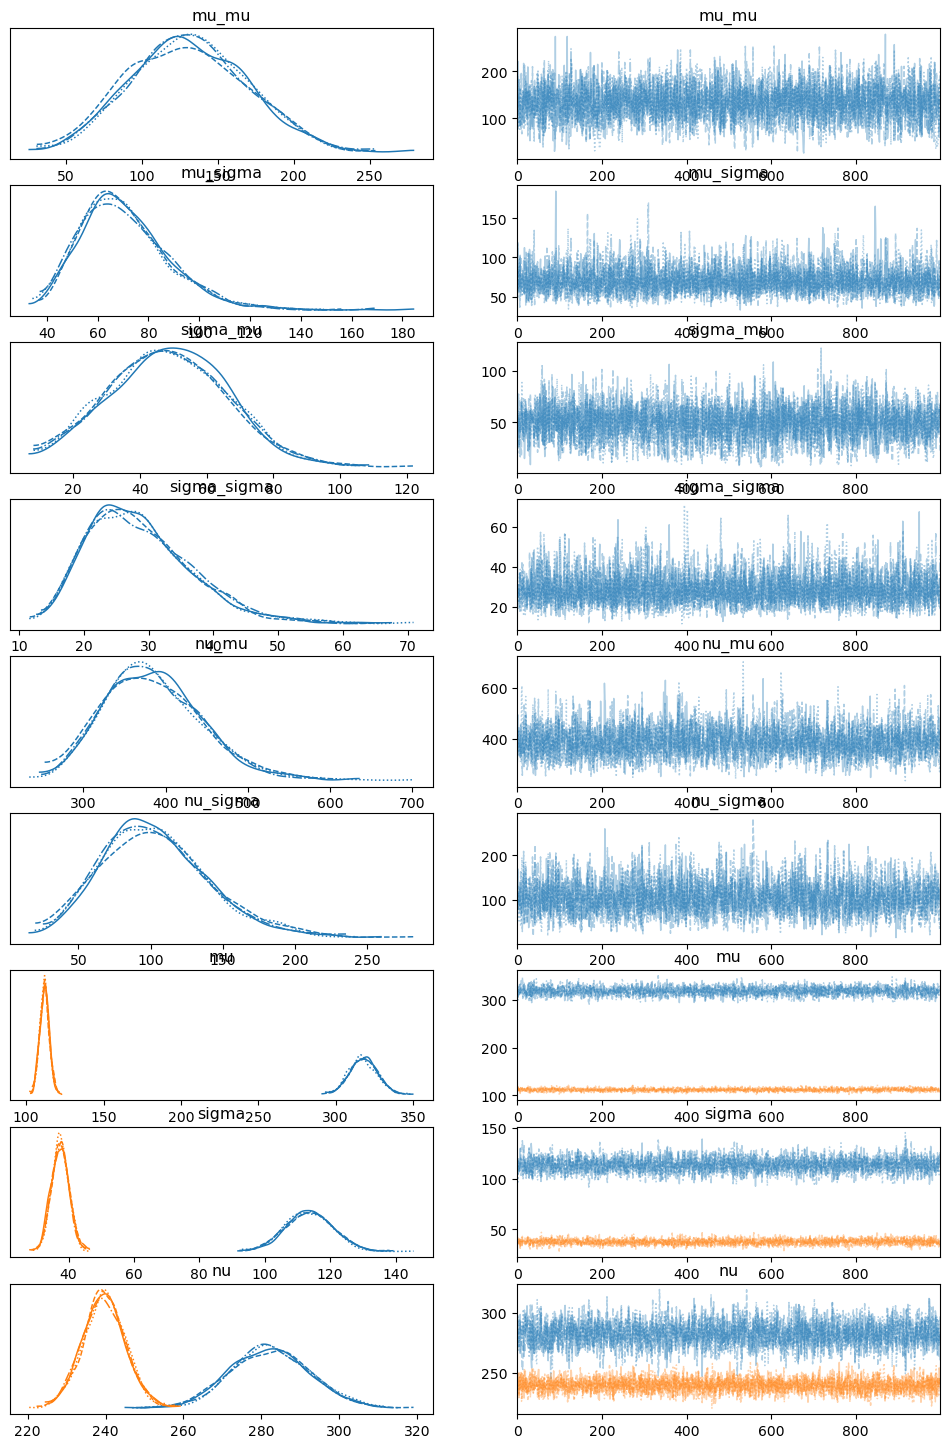

In [100]:
az.plot_trace(idata)

In [101]:
az.rhat(idata)

<xarray.Dataset>
Dimensions:         (spawn_category: 2)
Coordinates:
  * spawn_category  (spawn_category) <U10 'Far inland' 'Mid inland'
Data variables:
    mu_mu           float64 1.001
    mu_sigma        float64 1.0
    sigma_mu        float64 1.001
    sigma_sigma     float64 1.0
    nu_mu           float64 1.001
    nu_sigma        float64 1.002
    mu              (spawn_category) float64 1.001 1.001
    sigma           (spawn_category) float64 1.0 1.003
    nu              (spawn_category) float64 0.9999 1.0

#### [Model #2] Results
The trace plots and $\hat{R}$ values are much, much better than the previous model. The first-degree priors are well-defined, and separate (as I would expect). There are no divergences, and only one $\hat{R}$ value is outside the desired range at 1.003. This is a significant improvement over the previous model, and I expect the posterior predictive checks to be much better as well.

Sampling: [y]


/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


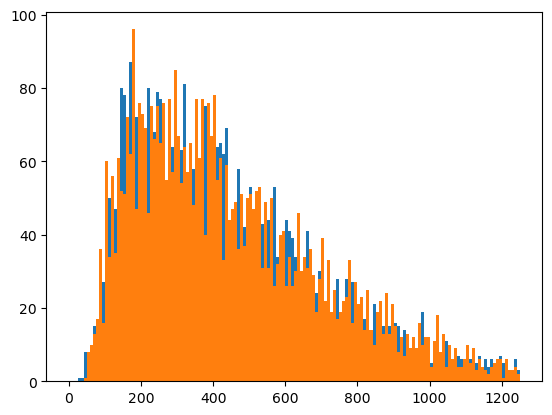

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


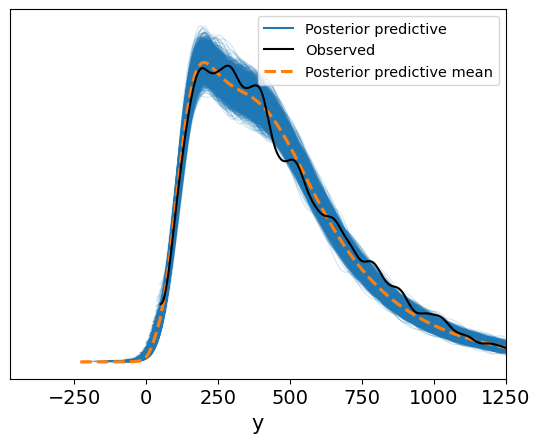

In [102]:
pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)

prediction = az.extract(idata, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values
plt.hist(prediction, bins=150, range=(0, 1250))
plt.hist(data.distance, bins=150, range=(0, 1250))

az.plot_ppc(idata).set_xbound(upper=1250)

#### [Model #2] Conclusion
This model is near-perfect, for the `Far inland` and `Mid inland` categories anyway. It doesn't quite capture the bumpiness, but it does capture the general shape of the data. The peak is in the right place, and the descent is properly captured. However, we're only modeling ~50% of our data. Next I'm going to try only removing the Ocean category, and see if I can improve the model without taking out the majority of the data.

In [108]:
data = pd.read_csv('seedscraper_out.csv', dtype={'spawn_category':'category'})

data = data[data.spawn_category != 'Ocean']#[data.spawn_category != 'Coast']#[data.spawn_category != 'Near inland']
data.spawn_category = data.spawn_category.cat.remove_unused_categories()

idx = data.spawn_category.cat.codes.values
coords = {"spawn_category": data.spawn_category.cat.categories}

In [109]:
with pm.Model(coords = coords) as model_last:
    mu_mu = pm.Gamma('mu_mu', mu = 100, sigma = 40)                                     # mean of means of normal
    mu_sigma = pm.Gamma('mu_sigma', mu = 50, sigma = 20)                                # std dev of means of normal

    sigma_mu = pm.Gamma('sigma_mu', mu = 30, sigma = 20)                                # mean of std devs of normal
    sigma_sigma = pm.Gamma('sigma_sigma', mu = 20, sigma = 10)                          # std dev of std devs of normal

    nu_mu = pm.Gamma('nu_mu', mu = 600, sigma = 100)                                    # mean of scales of exponential
    nu_sigma = pm.Gamma('nu_sigma', mu = 70, sigma = 30)                                # std dev of scales of exponential

    mu = pm.Gamma('mu', mu=mu_mu, sigma=mu_sigma, dims="spawn_category")                # mean of normal
    sigma = pm.Gamma('sigma', mu=sigma_mu, sigma=sigma_sigma, dims="spawn_category")    # std dev of normal
    nu = pm.Gamma('nu', mu=nu_mu, sigma=nu_sigma, dims="spawn_category")                # scale of exponential

    y = pm.ExGaussian('y', mu=mu[idx], sigma=sigma[idx], nu=nu[idx], observed=data.distance)

    idata_last = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, sigma_mu, sigma_sigma, nu_mu, nu_sigma, mu, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.


array([[<Axes: title={'center': 'mu_mu'}>,
        <Axes: title={'center': 'mu_mu'}>],
       [<Axes: title={'center': 'mu_sigma'}>,
        <Axes: title={'center': 'mu_sigma'}>],
       [<Axes: title={'center': 'sigma_mu'}>,
        <Axes: title={'center': 'sigma_mu'}>],
       [<Axes: title={'center': 'sigma_sigma'}>,
        <Axes: title={'center': 'sigma_sigma'}>],
       [<Axes: title={'center': 'nu_mu'}>,
        <Axes: title={'center': 'nu_mu'}>],
       [<Axes: title={'center': 'nu_sigma'}>,
        <Axes: title={'center': 'nu_sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

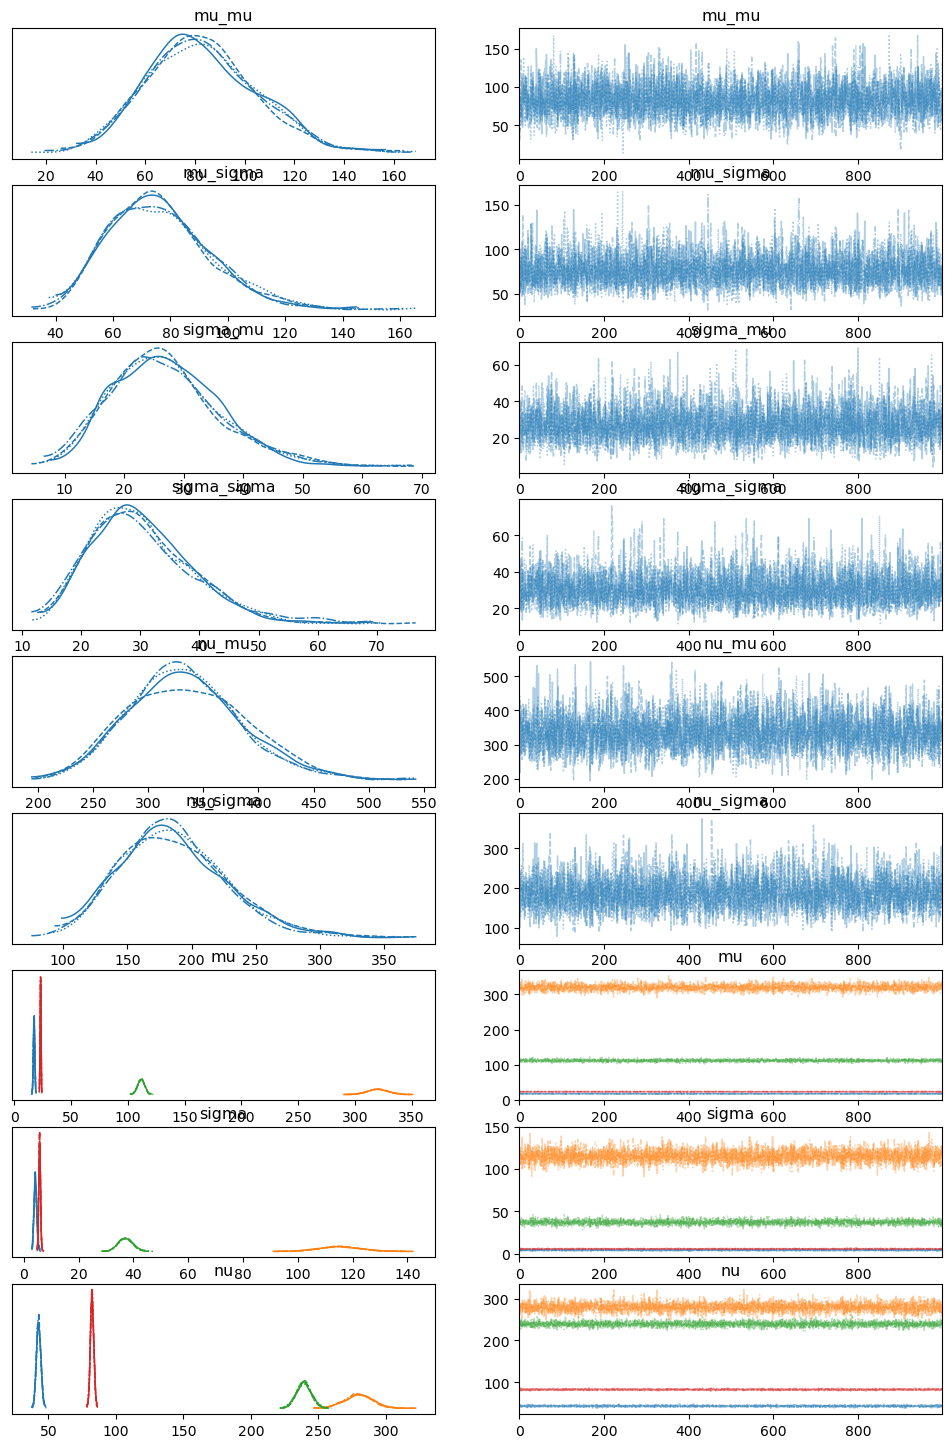

In [110]:
az.plot_trace(idata_last)

In [111]:
az.rhat(idata_last)

<xarray.Dataset>
Dimensions:         (spawn_category: 4)
Coordinates:
  * spawn_category  (spawn_category) <U11 'Coast' 'Far inland' ... 'Near inland'
Data variables:
    mu_mu           float64 1.0
    mu_sigma        float64 1.001
    sigma_mu        float64 1.001
    sigma_sigma     float64 1.002
    nu_mu           float64 1.003
    nu_sigma        float64 1.002
    mu              (spawn_category) float64 1.001 1.001 1.001 1.0
    sigma           (spawn_category) float64 1.003 1.001 1.002 1.002
    nu              (spawn_category) float64 1.001 1.0 1.002 1.0

#### [Model #3] Results
The trace plots and $\hat{R}$ values are very similar to the previous model. The trace plots are well-defined, and without the sharp spike of the `Ocean` category, actually visible. The $\hat{R}$ values are all very close to the desired range, at most 1.003 or 1.002. It also notably has 0 divergences. It looks like the `Ocean` category was the problem, so let's see the PPC.

Sampling: [y]


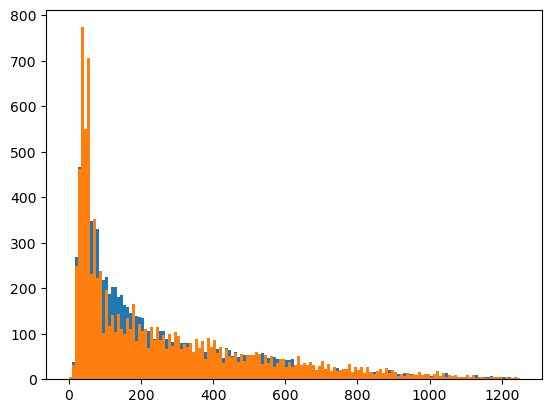

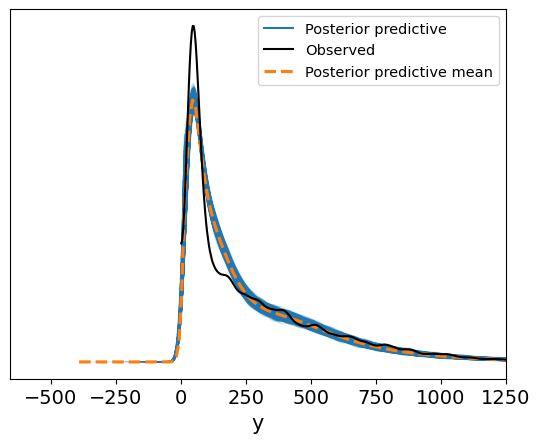

In [112]:
pm.sample_posterior_predictive(idata_last, model=model_last, extend_inferencedata=True)

prediction = az.extract(idata_last, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values
plt.hist(prediction, bins=150, range=(0, 1250))
plt.hist(data.distance, bins=150, range=(0, 1250))

az.plot_ppc(idata_last).set_xbound(upper=1250)

#### Conclusion
Interestingly, this looks almost identical to Model #1. There is no notable difference in the shape of the data. While I did expect it to appear more similar, given the shape of the `Coast` and `Near inland` categories, I did not expect it to be identical. However, it actually makes a lot of sense.

The `Ocean` category not only is horrible to  model, but also very small (which also makes modeling it worse). When it was included in the data, the model would have thousands of divergences as it failed to track it, but it ultimately isn't very much of the data and didn't affect the resultant shape much. Now that it is removed, the divergences are gone but the shape isn't affected.

Ultimately that makes Model #3 the best, as it is much easier (and faster) to run, while still modeling the vast, vast majority of the data. In fact, in application modeling the `Ocean` category is redundant when it is always 0. This model is the best of both worlds, and I am happy with the results.

That said, it does still have the issue from last project, of that gap in the data. I will need a different likelihood (probably a mixture of distributions) to capture that, which is a project for another day.

In [119]:
data = pd.read_csv('seedscraper_out.csv', dtype={'spawn_category':'category'})

print(f"{len(data[data.spawn_category == 'Ocean'])}/{len(data)}")

7/10000
